In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy.time import Time
import numpy as np
from obsutils.utils import SkyportalClient

In [2]:
instrument_id = 50 # BOSS is 50

In [3]:
source_name = "ZTF18aaotzun"

In [16]:
client = SkyportalClient()
client.set_up_session()

res = client.api(
    "GET", 
    f"sources/{source_name}",
    data={"includePhotometry": "false"}
)
src_data = res.json()["data"]

In [6]:
pos = coords.SkyCoord(src_data["ra"], src_data["dec"], frame='icrs', unit="deg")
xid = SDSS.query_region(pos, radius='1 arcsec', spectro=True)

In [7]:
specid = int(xid["specobjid"][0]) if len(xid) == 1 else None
print(f"Specid is {specid}")

Specid is 2077381330038974464


In [8]:
sp = SDSS.get_spectra(matches=xid)

In [9]:
data = sp[0][1].data

wl = 10.**data["loglam"]
flux = data["flux"]


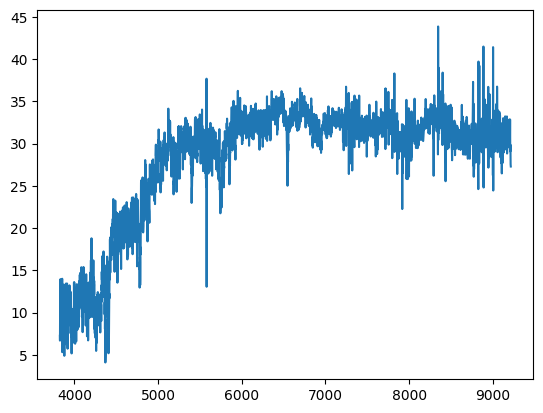

In [10]:
plt.plot(wl, flux)

In [11]:
mjd = Time(sp[0][0].header["MJD"], format="mjd")
mjd.isot

'2007-02-13T00:00:00.000'

In [13]:
filename = f"{specid}.ascii"

In [19]:
res = client.api(
    "GET", 
    f"sources/{source_name}/spectra",
)
existing_spectra = res.json()["data"]["spectra"]
filenames = [x["original_file_filename"] for x in existing_spectra]

In [25]:
payload = {
    "wavelengths": [float(x) for x in wl],
    "fluxes": [float(x) for x in flux],
    "observed_at": mjd.isot,
    "obj_id": source_name,
    "instrument_id": instrument_id,
    "group_ids": [1],
    # "filename": filename,
}

In [27]:
if specid is not None:
    if filename not in filenames:
        print(f"Uploading spectrum {filename}")
        res = client.api(
            "POST", 
            "spectra",
            data=payload
        )
        res.raise_for_status()
        res.json()
    else:
        print(f"Spectrum {filename} exists")

Uploading spectrum 2077381330038974464.ascii
